In [99]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os.path

cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
print(src)
print(root)
sys.path.append(str(src))
sys.path.append(str(root))

/Users/matskerver/Documents/GIT/MDP_git/Git_mdp
/Users/matskerver/Documents/GIT/MDP_git


In [100]:
from superflexpy.implementation.elements.gr4j import BaseElement, UnitHydrograph1, UnitHydrograph2, FluxAggregator 
from superflexpy.implementation.elements.gr4j import InterceptionFilter, ProductionStore, RoutingStore
from superflexpy.implementation.elements.structure_elements import Transparent, Splitter, Junction
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network
#from utils.precipitation_evaporation import *

In [101]:
def GR4J_element(x1,x2,x3,x4, name, area, precipitation, evaporation):
    #x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5)

    root_finder = PegasusPython()  # Use the default parameters
    numerical_approximation = ImplicitEulerPython(root_finder)

    interception_filter = InterceptionFilter(id='ir')

    production_store = ProductionStore(parameters={'x1': x1, 'alpha': 2.0,
                                                   'beta': 5.0, 'ni': 4/9},
                                       states={'S0': 10.0},
                                       approximation=numerical_approximation,
                                       id='ps')

    splitter = Splitter(weight=[[0.9], [0.1]],
                        direction=[[0], [0]],
                        id='spl')

    unit_hydrograph_1 = UnitHydrograph1(parameters={'lag-time': x4},
                                        states={'lag': None},
                                        id='uh1')

    unit_hydrograph_2 = UnitHydrograph2(parameters={'lag-time': 2*x4},
                                        states={'lag': None},
                                        id='uh2')

    routing_store = RoutingStore(parameters={'x2': x2, 'x3': x3,
                                             'gamma': 5.0, 'omega': 3.5},
                                 states={'S0': 10.0},
                                 approximation=numerical_approximation,
                                 id='rs')

    transparent = Transparent(id='tr')

    junction = Junction(direction=[[0, None],  # First output
                                   [1, None],  # Second output
                                   [None, 0]], # Third output
                        id='jun')

    flux_aggregator = FluxAggregator(id='fa')

    catchment_element = Unit(layers=[[interception_filter],
                     [production_store],
                     [splitter],
                     [unit_hydrograph_1, unit_hydrograph_2],
                     [routing_store, transparent],
                     [junction],
                     [flux_aggregator]],
             id=f'unit-{name}')
    
    
    current_node = Node(
    units=[catchment_element],
    weights = [1.0],
    area=area,
    id=f'node-{name}'
    )
    
    current_node.set_input([precipitation, evaporation])
    print(precipitation)
    return current_node

In [102]:
x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5)
areas = [1.0, 4.6, 2.6, 9.1]
precipitation = [[40., 15.4,8.,3.3],[30., 15.4,8.,3.3],[10., 15.4,8.,3.3],[80., 15.4,8.,3.3]]
evaporation = [[4., 2.4,18.,6.3],[4., 2.4,18.,6.3],[4., 2.4,18.,6.3],[4., 2.4,18.,6.3]]

In [103]:
nodes_gr4j = []


for i in range(4):
    name = str(i+1)
    current = GR4J_element(x1, x2, x3, x4, name, areas[i], precipitation[i], evaporation[i])
    nodes_gr4j.append(current)
    print(current.id)
    
print(type(nodes_gr4j[0]))

[40.0, 15.4, 8.0, 3.3]
node-1
[30.0, 15.4, 8.0, 3.3]
node-2
[10.0, 15.4, 8.0, 3.3]
node-3
[80.0, 15.4, 8.0, 3.3]
node-4
<class 'superflexpy.framework.node.Node'>


In [104]:
net = Network(
    nodes=nodes_gr4j,
    topology={
        'node-1': 'node-3',
        'node-2': 'node-3',
        'node-3': 'node-4',
        'node-4': None
    }
)

In [105]:
net.reset_states()
net.set_timestep(1.0)
output = net.get_output()


In [106]:
output_unit_1_node_1 = net.call_internal(id='node-1_unit-1',
                                        method='get_output',
                                        solve=False)[0]
output_unit_2_node_2 = net.call_internal(id='node-2_unit-2',
                                        method='get_output',
                                        solve=False)[0]
output_unit_3_node_3 = net.call_internal(id='node-3_unit-3',
                                        method='get_output',
                                        solve=False)[0]
output_unit_4_node_4 = net.call_internal(id='node-4_unit-4',
                                        method='get_output',
                                        solve=False)[0]




TypeError: unhashable type: 'dict'

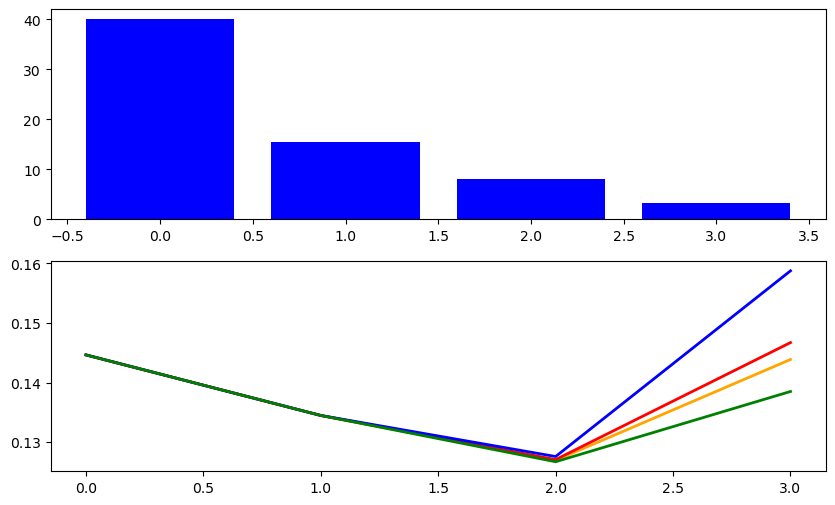

In [107]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))

# plot first figure
ax1.bar(x=range(len(precipitation)), height=precipitation[0], color='blue', label='precipitation')
ax2.plot(range(len(precipitation)), output_unit_1_node_1, color='orange', lw=2, label='Node 1')
ax2.plot(range(len(precipitation)), output_unit_2_node_2, color='red', lw=2, label='Node 2')
ax2.plot(range(len(precipitation)), output_unit_3_node_3, color='blue', lw=2, label='Node 3')
ax2.plot(range(len(precipitation)), output_unit_4_node_4, color='green', lw=2, label='Node 4')
ax2.plot(range(len(precipitation)), output, color='pink', lw=2, label='Network')

ax1.legend()
ax1.set_xlabel('Time [days]')
ax1.set_ylabel("precipitation [mm/day]")


plt.show()